
<!-- README.md is generated from README.ipynb. Please edit that file -->

# pyramid-learn <img src="docs/logo/logo_hex.png" align="right" height="138"/>

A [{rpy2}](https://rpy2.github.io/doc/latest/html/)-based Python wrapper for the [{midr}](https://ryo-asashi.github.io/midr/) R package to explain black-box models, with a [{scikit-learn}](https://scikit-learn.org/stable/) compatible API.

The goal of {midr} is to provide a model-agnostic method for interpreting and explaining black-box predictive models by creating a globally interpretable surrogate model.
The package implements 'Maximum Interpretation Decomposition' (MID), a functional decomposition technique that finds an optimal additive approximation of the original model.
This approximation is achieved by minimizing the squared error between the predictions of the black-box model and the surrogate model.
The theoretical foundations of MID are described in Iwasawa & Matsumori (2025) \[Forthcoming\], and the package itself is detailed in [Asashiba et al. (2025)](https://arxiv.org/abs/2506.08338).

## Installation

You can install the package directly from GitHub:

```bash
pip install git+https://github.com/ryo-asashi/pyramid-learn.git
```

## Features

- **Scikit-learn Compatible API**: Fits seamlessly into your existing 'scikit-learn' workflows with a familiar .fit() and .predict() interface.

- **Model-Agnostic IML**: Explains any black-box model, from complex neural networks to gradient boosting machines.

- **Global Interpretability**: Generates a simple, additive surrogate model (MID) that provides a global understanding of the black-box model's behavior.

- **Direct Visualizations**: Easily creates plots for feature importance, component functions (dependence), prediction breakdowns, and conditional expectations using a plotnine-based interface.

## Requirements

This package is a {rpy2}-based Python wrapper and requires a working R installation on your system, as well as the {midr} R package.

You can install the R package from CRAN by running the following command in your R console:

```r
install.packages('midr')
```

## Quick Start

Here’s a basic example of how to use **pyramid-learn** (namespace: **midlearn**) to explain a trained LightGBM model.

In [184]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn import set_config

import lightgbm as lgb
import midlearn as mid # pyramid-learn

import plotnine as p9

set_config(display='text')
p9.theme_set(p9.theme_bw(base_family='serif'))
p9.options.figure_size = (5, 4)

### Train a black-box model

In [201]:
bikeshare = fetch_openml(data_id=1414)
X = pd.DataFrame(bikeshare.data, columns=bikeshare.feature_names)
y = bikeshare.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(pd.concat([X_train.head(), y_train.head()], axis=1).to_markdown(index=False))

| time     |   season |   holiday |   workingday |   weather |   temp |   atemp |   humidity |   windspeed | dayOfWeek   |   count |
|:---------|---------:|----------:|-------------:|----------:|-------:|--------:|-----------:|------------:|:------------|--------:|
| 00:00:00 |        3 |         0 |            1 |         1 |  28.7  |  32.575 |         65 |      12.998 | woensdag    |      35 |
| 22:00:00 |        2 |         0 |            1 |         1 |  22.96 |  26.515 |         52 |     220.028 | zondag      |     251 |
| 23:00:00 |        2 |         0 |            1 |         1 |  12.3  |  15.91  |         61 |      60.032 | vrijdag     |      53 |
| 09:00:00 |        3 |         0 |            0 |         1 |  23.78 |  27.275 |         60 |      89.981 | dinsdag     |     296 |
| 23:00:00 |        1 |         0 |            1 |         3 |   8.2  |   9.85  |         93 |      12.998 | dinsdag     |      16 |


In [186]:
# Fit a LightGBM regression model
estimator = lgb.LGBMRegressor(random_state=42)
estimator.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 260
[LightGBM] [Info] Number of data points in the train set: 8164, number of used features: 10
[LightGBM] [Info] Start training from score 191.339784


LGBMRegressor(random_state=42)

### Use pyramid-learn to explain the model

In [187]:
# Fit a MID model as a global surrogate explainer
explainer = mid.MIDExplainer(
    estimator=estimator,
    interaction=True,
    params_main=50,
    penalty=.5
)
explainer.fit(X_train)

Generating predictions from the estimator...


MIDExplainer(estimator=LGBMRegressor(random_state=42), params_main=50,
             penalty=0.5)

In [188]:
# Check the uninterpreted variation ratio of the explainer
explainer.ratio

0.03612861020533493

In [200]:
# Show the main effect of Time
print(explainer.main_effects('time').head().to_markdown(index=False))

'| time     |   time_level |   density |      mid |\n|:---------|-------------:|----------:|---------:|\n| 00:00:00 |            1 | 0.0428711 | -129.537 |\n| 01:00:00 |            2 | 0.0410338 | -146.968 |\n| 02:00:00 |            3 | 0.0422587 | -153.064 |\n| 03:00:00 |            4 | 0.0400539 | -167.218 |\n| 04:00:00 |            5 | 0.0412788 | -164.439 |'

Generating predictions from the estimator...
R-squared score: 0.9604320788152169


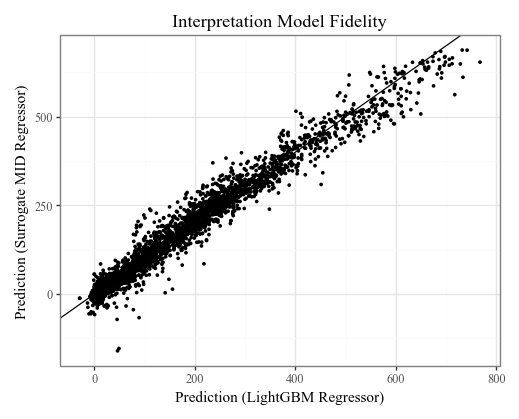

In [190]:
# Check the fidelity of the surrogate model to the original model
print("R-squared score:", explainer.fidelity_score(X_test))

p = p9.ggplot() \
    + p9.geom_abline(slope=1) \
    + p9.geom_point(p9.aes(estimator.predict(X_test), explainer.predict(X_test)), shape='.') \
    + p9.labs(
        x='Prediction (LightGBM Regressor)',
        y='Prediction (Surrogate MID Regressor)'
    )
display(p + p9.ggtitle("Interpretation Model Fidelity"))

### Visualize and analyze the results

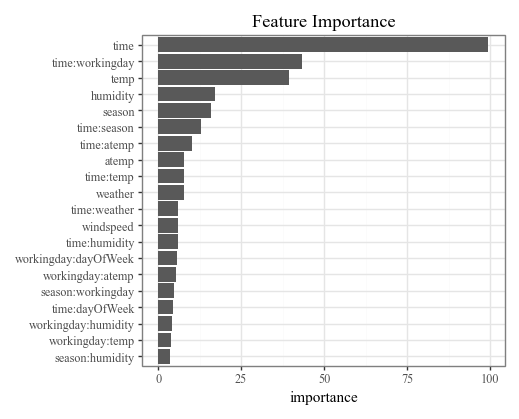

In [191]:
# Plot overall feature importance
imp = explainer.importance()
display(imp.plot(max_nterms=20) + p9.ggtitle("Feature Importance"))

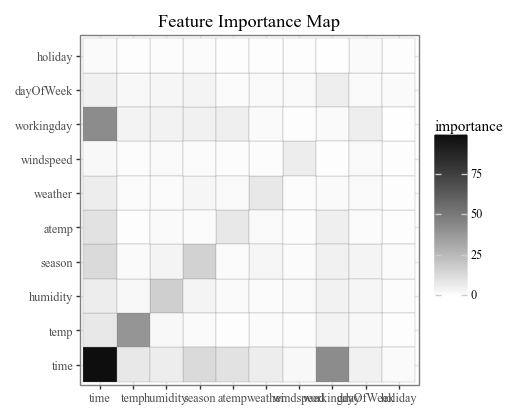

In [192]:
# Plot overall feature importance as a heatmap
p = imp.plot(style='heatmap', color='#808080')
display(p + p9.ggtitle("Feature Importance Map"))

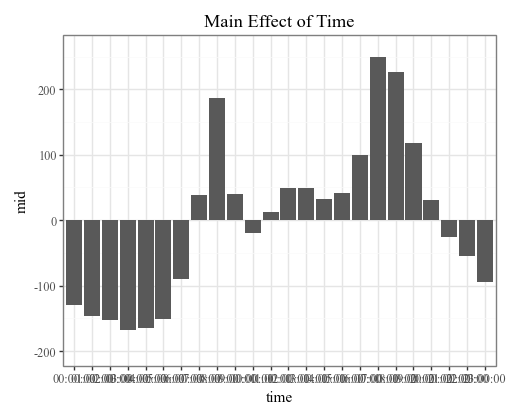

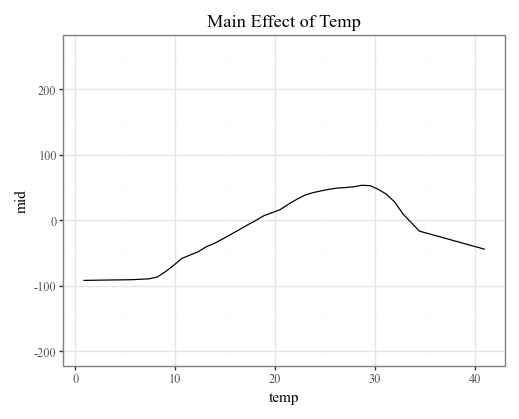

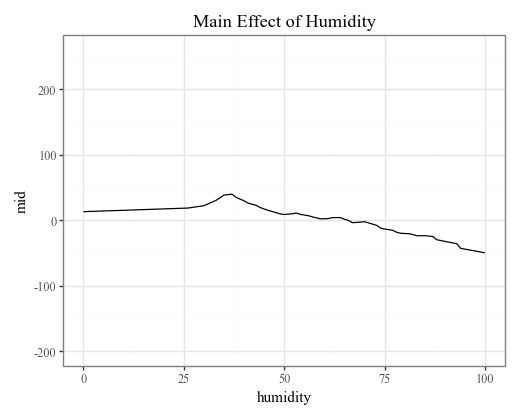

In [193]:
# Plot important main effects
for i, t in enumerate(imp.terms(interactions=False)[:3]):
    p = explainer.plot(term=str(t)) + p9.lims(y = [-200, 260])
    display(p + p9.ggtitle(f"Main Effect of {t.capitalize()}"))

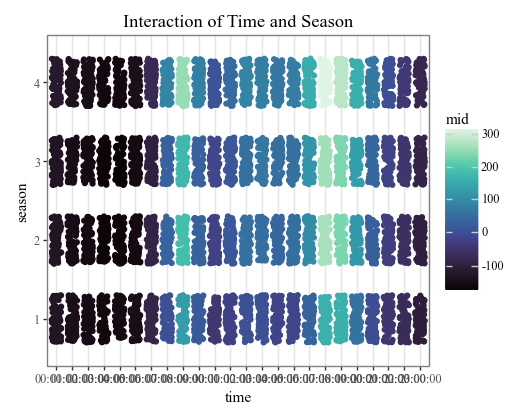

In [194]:
# Plot important two-way interactions (with main effects)
p = explainer.plot(
    'time:season',
    style='data',
    data=X_train,
    main_effects=True,
    theme='mako'
)
display(p + p9.ggtitle("Interaction of Time and Season"))

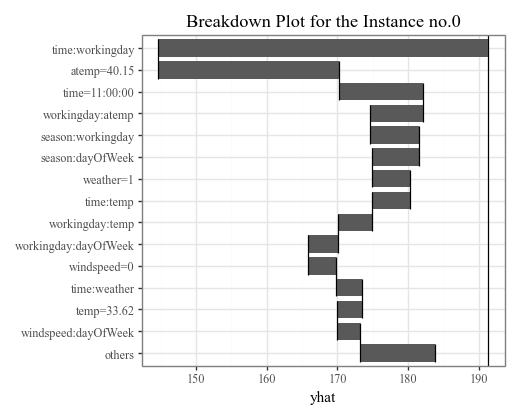

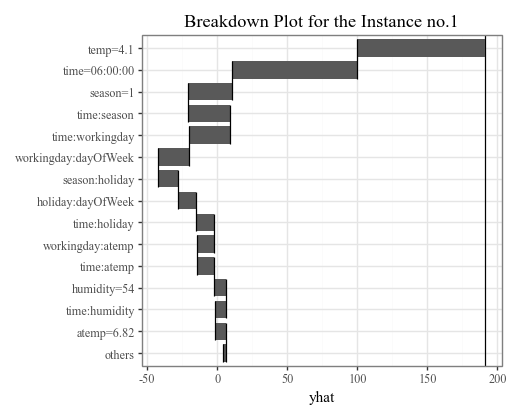

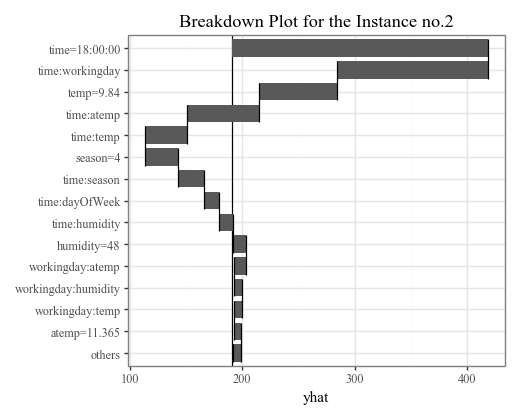

In [202]:
# Plot prediction breakdowns for the first three rows in the testing dataset
for i in range(3):
    p = explainer.breakdown(row=i, data=X_test).plot()
    display(p + p9.ggtitle(f"Breakdown Plot for the Instance no.{i}"))

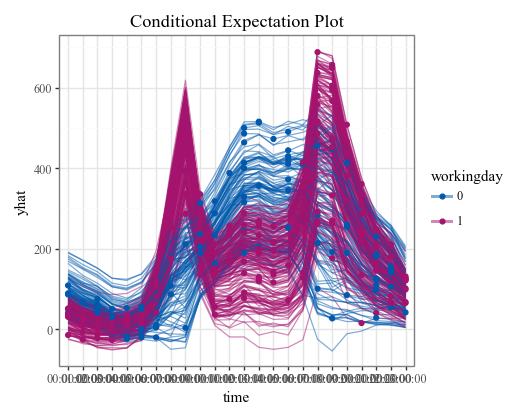

In [196]:
# Plot individual conditional expectations
p = explainer.conditional('time', data=X_test.head(300)). \
    plot(var_color='workingday', theme='midr@q', alpha=.5)
display(p + p9.ggtitle("Conditional Expectation Plot"))